> Read VAE and VQ-VAE before coming to this blog. 

> We will discuss about VQVAE and how autoregressive image modelling works.

> We will also discuss how conditioning is applied to these models. 


VQ-GAN is a family of models which uses auto encoding to reduce the dimensionality of the image and use transformers for the generative aspect of it. 

The model is trained in two stages.
- Train Encoder, quantizer and decoder.
- taking quantizer outputs to train a generative model using autoregressive transformers. 


> The paper also talks about generating megapixel images by using a sling window approch conditioning on previous windows. 

> As usual we will try to make this notebook as informative as possible with minimum dependencies.

## VQGAN
the paper claims that the quality of the reconstructions using VAE detoriates as we increase the receptive field. so we will use a GAN to train the E-Q-D architecture. The model uses LPIPS loss instead of L2 loss, also adds a patch based discrimintor along with commitement and codebook loss (discussed in vqvae).

In [1]:
import torch
import os 
import torchvision
import fastcore.all as fc
import numpy as np 
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline

In [2]:
DEVICE="cuda:0"

In [3]:
#Load MNIST data and resize it to 32x32
MEAN = (0.1307,)
STD = (0.3081,)
transforms =  torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.2),  # Horizontal flip
    torchvision.transforms.RandomVerticalFlip(p=0.2),    # Vertical flip
    torchvision.transforms.RandomApply([torchvision.transforms.RandomAffine(
        degrees=15,                          # Rotation range
        translate=(0.1, 0.1),                # Horizontal and vertical shifts
        scale=(0.8, 1.2),                    # Random scaling
        shear=15                             # Shear angle in degrees
    )], p=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomErasing(p=0.2, scale=(0.02, 0.15)),
    torchvision.transforms.Pad(2),
    torchvision.transforms.Normalize(mean=MEAN, std=STD)  # MNIST standard normalization
    
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True, transform=transforms),
    batch_size=128, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True, transform=transforms),
                               batch_size=128, shuffle=False)

len(train_loader), len(val_loader)


# train_loader = torch.utils.data.DataLoader(
#     torchvision.datasets.MNIST('data/', train=True, download=True,
#                                 transform=torchvision.transforms.Compose([
#                                     torchvision.transforms.Pad(2),
#                                     torchvision.transforms.ToTensor()
#                                 ])),
#     batch_size=128, shuffle=True)

# val_loader = torch.utils.data.DataLoader(
#     torchvision.datasets.MNIST('data/', train=False, download=True,
#                                 transform=torchvision.transforms.Compose([
#                                     torchvision.transforms.Pad(2),
#                                     torchvision.transforms.ToTensor()
#                                 ])),
#     batch_size=128, shuffle=False)

# len(train_loader), len(val_loader)

(469, 79)

In [4]:
imgs, labels = next(iter(val_loader))
imgs.shape, labels.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

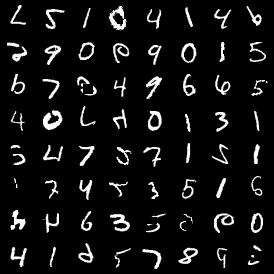

In [ ]:
pimg = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((imgs[:64]*STD[0])+MEAN[0], nrow=8))
pimg

In [6]:
# make two pil images store side by side 
def combine_images_horizontally(img1, img2):
    # Get dimensions
    width1, height1 = img1.size
    width2, height2 = img2.size
    
    # Calculate the maximum height
    max_height = max(height1, height2)
    
    # Create a new image with width = sum of widths, height = max height
    combined_width = width1 + width2
    combined_image = Image.new('RGB', (combined_width, max_height))
    
    # Paste the images side by side
    combined_image.paste(img1, (0, 0))
    combined_image.paste(img2, (width1, 0))
    return combined_image

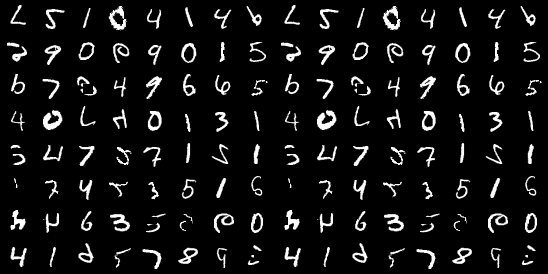

In [7]:
combine_images_horizontally(pimg, pimg)

> we will use model from Llamagen and train a tiny net.

> we will train for 30 epochs with very small learning rate. 

In [8]:
from vqgan import VQModel, ModelArgs
cfg = ModelArgs(
    codebook_size=2048, 
    codebook_embed_dim=8, 
    codebook_l2_norm=True, 
    codebook_show_usage=True, 
    commit_loss_beta=0.25, 
    entropy_loss_ratio=0.0, 
    encoder_ch_mult=[1, 2, 2], 
    decoder_ch_mult=[1, 2, 2], 
    z_channels=256, 
    dropout_p=0.0, 
)
vqgan = VQModel(cfg)
vqgan.to(DEVICE)
print("model loaded")

model loaded


In [9]:
params = 0
for param in vqgan.parameters():
    params += param.numel()
params

6046153

In [10]:
dec, loss, info = vqgan.encode(torch.randn(1, 1, 32, 32).to(DEVICE))
dec.shape, loss, info[2].shape

(torch.Size([1, 8, 8, 8]),
 (tensor(0.0234, device='cuda:0', grad_fn=<MeanBackward0>),
  tensor(0.0059, device='cuda:0', grad_fn=<MulBackward0>),
  tensor(-0., device='cuda:0', grad_fn=<MulBackward0>),
  0.03125),
 torch.Size([64]))

## perplexity 

In [11]:
codebook_usage = torch.zeros(vqgan.quantize.n_e)
codebook_usage.shape

torch.Size([2048])

In [12]:
for c in info[2].view(64, -1).cpu().numpy():
    codebook_usage[c] += 1
codebook_usage

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [13]:
def calculate_perplexity(codebook_usage):
    # codebook_usage is a histogram of codebook indices
    probs = codebook_usage / codebook_usage.sum()
    entropy = -torch.sum(probs * torch.log2(probs + 1e-10))
    perplexity = 2 ** entropy
    return perplexity

In [14]:
calculate_perplexity(codebook_usage) #ideally we need 4096 perplexity score to make it a good quantizer.

tensor(62.6286)

## GAN 
In GANs, we have a generator and a discriminator. The discriminator needs to distinguish between the real and fake samples. 

We update the discriminator weights using binary cross entropy loss where real samples should be classified as 1 and fake samples as 0. The generator (encoder and decoder) is updated using a generator loss obtained by trying to fool the discriminator into classifying generated images as real (1).

Discriminator loss: $$ \mathcal{L}_D = -\mathbb{E}_{x \sim p_{data}}[\log D(x)] - \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))] $$

Generator loss: $$ \mathcal{L}_G = -\mathbb{E}_{z \sim p_z}[\log D(G(z))] $$


The equations show the standard GAN loss functions where:
- The discriminator tries to maximize the probability of correctly classifying both real and fake samples
- The generator tries to minimize the probability of the discriminator correctly identifying its outputs as fake

> The following things needs to be implemented to train a VQGAN
- discrimintor 
- GAN loss 
- lpips 
- commitment and codebook loss 
- $\lambda$ - adaptive weight. 


## Final losses
- the generator loss is defined as  genloss + adaptive_weight * (rec loss + lpips_loss + commitment loss + code book loss)
- the discriminator loss is just the binary cross entropy lass as seen above. 


## Discriminator 
In the original paper they implemented Patch based discrimintor obtained from pix2pix paper. we will implement a variant of it here. the original paper tried to generate mega pixel size images and hence patched inputs before sending it to the network. Here we don't need it as our images are already very small in size.

In [15]:
def _conv(input_nc, ndf, ks, stride, pad, norm=True):
    conv = torch.nn.Conv2d(input_nc, ndf, kernel_size=ks, stride=stride, padding=pad)
    act = torch.nn.LeakyReLU(0.2, True)
    out = [conv, act]
    if norm: out.append(torch.nn.BatchNorm2d(ndf))
    return torch.nn.Sequential(*out)

class Disc(torch.nn.Module):
    def __init__(self, input_nc=3, ndf=64):
        super(Disc, self).__init__()
        self.layer1 = _conv(input_nc, ndf, 4, 2, 1, norm=False)
        self.layer2 = _conv(ndf, ndf*2, 4, 2, 1)
        self.layer3 = _conv(ndf*2, ndf*2, 4, 2, 1)
        self.layer4 = _conv(ndf*2, ndf*4, 4, 1, 1)
        self.final = torch.nn.Conv2d(ndf*4, 1, kernel_size=4, padding=1)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.final(x)
        return x 

In [16]:
disc = Disc(1, 64)
disc(imgs).shape

torch.Size([128, 1, 2, 2])

In [17]:
params = 0
for param in disc.parameters():
    params+=param.numel()
params

924225

## LPIPS and GAN loss implementation 

> for LPIPS we will use [lpips package](https://github.com/richzhang/PerceptualSimilarity/tree/master) directly. 

> we will use MSELoss as defined in LSGAN paper.

In [18]:
import lpips
class PerceptionLoss(torch.nn.Module):
    def __init__(self):
        super(PerceptionLoss, self).__init__()
        self.lpips = lpips.LPIPS(net="vgg")

    def forward(self, generated, target):
        return self.lpips(generated, target).mean()


class GANLoss(torch.nn.Module):
    """
    GAN loss
    """

    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer("real_label", torch.tensor(target_real_label))
        self.register_buffer("fake_label", torch.tensor(target_fake_label))
        if use_lsgan:
            self.loss = torch.nn.MSELoss()
        else:
            self.loss = torch.nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(input)

    def forward(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)
    

    def generator_loss(self, generated):
        return self.forward(generated, True)

    def discriminator_loss(self, generated, real):
        real_loss = self.forward(real, True)
        fake_loss = self.forward(generated, False)
        return (real_loss + fake_loss) / 2
    
    

In [19]:
gloss = GANLoss(use_lsgan=False)

In [20]:
#ze = vqgan.encode(imgs.to(DEVICE))
quant, emb_loss, info = vqgan.encode(imgs.to(DEVICE))
quant.shape, emb_loss, info

(torch.Size([128, 8, 8, 8]),
 (tensor(0.0242, device='cuda:0', grad_fn=<MeanBackward0>),
  tensor(0.0060, device='cuda:0', grad_fn=<MulBackward0>),
  tensor(-0., device='cuda:0', grad_fn=<MulBackward0>),
  0.61865234375),
 (None,
  None,
  tensor([1229, 1843, 1951,  ..., 1917, 1318,  211], device='cuda:0')))

## Training VQGAN

we have several losses. since there are two networks. we will write the losses for each one separately

The generator has 
- codebook and commiment loss.
- reconstruction loss L1 loss $\mathcal{L}_\text{rec}$
- LPIPS loss 
- Discrimintor loss - starting after 50 epochs. $\mathcal{L}_\text{GAN}$

In the VQGAN paper, they claimed in the paper 
- (l1 + perpetual_wieght * lpip loss + (codebook + commitment loss) * codebook weight ) + \
adaptive_weight * disc_factor * disc_loss
- adaptive_weight is weightage calculated using 

$$
\lambda = \frac{\nabla_{G_L}[\mathcal{L}_\text{rec}]}{\nabla_{G_L}[\mathcal{L}_\text{GAN}] + \delta}
$$


The discriminator has 
- disc loss 





In [21]:
def calculate_adaptive_weight(nll_loss, g_loss, discriminator_weight=1, last_layer=None):
    # retain graph allows u to compute gradient again
    nll_grads = torch.autograd.grad(nll_loss, last_layer, retain_graph=True)[0]
    g_grads = torch.autograd.grad(g_loss, last_layer, retain_graph=True)[0]
    
    d_weight = torch.norm(nll_grads) / (torch.norm(g_grads) + 1e-4)
    d_weight = torch.clamp(d_weight, 0.0, 1e4).detach()
    d_weight = d_weight * discriminator_weight
    return d_weight

Bias correction is a technique used to address a problem that occurs at the beginning of training when using exponential moving averages. Here's why it's needed:

The Problem (Initial Bias):
When we start training, all our EMA values start from 0 (or initial weights) With a high beta (like 0.9999), the early estimates are heavily biased toward zero/initial values This creates a significant "warm-up" period where the EMA estimates are not representative

Let's break this down mathematically:

$$
v_{t} = \beta * v_{t-1} + (1-\beta) * x_{t}
$$
 
Where:
- $v_{t}$ is the EMA at time t
- $x_{t}$ is the current value
- $\beta$ is the decay rate (like 0.9999)

For example, let's say we have a constant value of 1.0 and β = 0.9:
- At t=1: v₁ = 0.1 (far from true value)
- At t=2: v₂ = 0.19
- At t=3: v₃ = 0.271
...and so on

The Solution (Bias Correction):
Bias correction adjusts for this initial bias by dividing by (1 - β^t):

$$
v_t^{corrected} = \frac{v_t}{1-\beta^t}
$$

Using the same example:
- At t=1: v₁ = 0.1 / (1-0.9¹) = 1.0
- At t=2: v₂ = 0.19 / (1-0.9²) = 1.0
- At t=3: v₃ = 0.271 / (1-0.9³) = 1.0

In [22]:
import copy

def exists(val):
    return val is not None

class EMA():
    def __init__(self, beta, beta_correction=True):
        super().__init__()
        self.beta = beta
        self.beta_correction = beta_correction
        self.step = 0
    def update_average(self, old, new):
        if not exists(old):
            return new
        if self.beta_correction:
            self.step+=1
            beta_correction = 1-self.beta**self.step
        else:
            beta_correction=1
        return old * self.beta + (1 - self.beta) * new/beta_correction

ema = EMA(beta=0.9999)
#ema_vqgan = copy.deepcopy(vqgan)
ema_vqgan = VQModel(cfg)
ema_vqgan.load_state_dict(vqgan.state_dict())
ema_vqgan.to(DEVICE)
print("Loaded EMA model")
#ema_vqgan = type(vqgan)(*vqgan.__init_args__, **vqgan.__init_kwargs__)
#ema_vqgan.load_state_dict(vqgan.state_dict().copy())

Loaded EMA model


In [4]:
storage_loc = fc.Path("generated/exp8")
storage_loc.mkdir(parents=True, exist_ok=True)

In [23]:
epochs = 400 
gan_epoch_start = 50
disc = Disc(1, 64).to(DEVICE)
gan_loss = GANLoss().to(DEVICE)
perception_loss = PerceptionLoss().to(DEVICE)
learning_rate = 4.5e-06 * 2
gloss_weight = 0.001
opt_ae = torch.optim.Adam(vqgan.parameters(), lr=learning_rate, betas=(0.5, 0.9))
opt_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.9))

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/prakash/genai/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/prakash/genai/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/prakash/genai/.venv/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


In [24]:
from collections import defaultdict
epoch_losses = []
val_epoch_losses = []
running_losses = defaultdict(float)
val_running_losses = defaultdict(float)
num_batches = 0
val_num_batches = 0
for epoch in range(epochs):
    vqgan.train()
    disc.train()
    with tqdm(train_loader, total=len(train_loader), desc="Training", leave=False) as pbar:
        for i, (x, _) in enumerate(pbar):
            x = x.to(device=DEVICE)
            x_out, (codebook_loss, commit_loss, _, _), _ = vqgan(x)
            lpips_loss = perception_loss(x_out, x)
            rec_loss = torch.nn.functional.l1_loss(x_out, x)
            total_g_loss = rec_loss + lpips_loss + codebook_loss + commit_loss
            if epoch>=gan_epoch_start:
                fake = disc(x_out)
                gloss = gan_loss.generator_loss(fake)
                dloss_weight = calculate_adaptive_weight(rec_loss, gloss, discriminator_weight=1, last_layer=vqgan.decoder.conv_out.weight)
                gloss = gan_loss.generator_loss(fake) * dloss_weight * gloss_weight
            else:
                gloss = torch.tensor(0.0)
            total_g_loss += gloss
            total_g_loss.backward()
            opt_ae.step()

            if epoch>=gan_epoch_start:
                d_loss = gan_loss.discriminator_loss(disc(x_out.detach()), disc(x)) * gloss_weight
                d_loss.backward()
                opt_disc.step()
            else:
                d_loss = torch.tensor(0.0)
            running_losses["total_g_loss"] += total_g_loss.item()
            running_losses["gloss"] += gloss.item()
            running_losses["d_loss"] += d_loss.item()
            running_losses["rec_loss"] += rec_loss.item()
            running_losses["lpips_loss"] += lpips_loss.item()
            running_losses["codebook_loss"] += codebook_loss.item()
            running_losses["commit_loss"] += commit_loss.item()
            num_batches += 1

            #update ema model 
            for current_params, ma_params in zip(vqgan.parameters(), ema_vqgan.parameters()):
                    old_weight, up_weight = ma_params.data, current_params.data
                    ma_params.data = ema.update_average(old_weight, up_weight)
            
            pbar.set_postfix(epoch=epoch, loss=total_g_loss.item(), rec_loss=running_losses["rec_loss"]/num_batches, lpips_loss=running_losses["lpips_loss"]/num_batches, codebook_loss=running_losses["codebook_loss"]/num_batches, commit_loss=running_losses["commit_loss"]/num_batches)
        epoch_averages = {key: value / num_batches for key, value in running_losses.items()}
        epoch_losses.append(epoch_averages)

    
    vqgan.eval()
    disc.eval()
    ema_vqgan.eval()
    with tqdm(val_loader, total=len(val_loader), desc="Validating", leave=False) as pbar:
        codebook_usage = torch.zeros(vqgan.quantize.n_e)
        for i, (x, _) in enumerate(pbar):
            with torch.no_grad():   
                x = x.to(device=DEVICE)
                x_ema_out, (_, _, _, _), (_, _, min_encoding_indices) = ema_vqgan(x)
                if i == 0:
                    x_out, (_, _, _, _), _ = vqgan(x)
                    x_out = torch.clamp(x_out*STD[0]+MEAN[0], 0, 1)
                    x_ema_out = torch.clamp(x_ema_out*STD[0]+MEAN[0], 0, 1)
                    #save the generated images
                    original_imgs =  torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((x*STD[0])+MEAN[0], nrow=8))
                    generated_imgs = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(x_out, nrow=8))
                    ema_generated_imgs = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(x_ema_out, nrow=8))
                    combine_images_horizontally(generated_imgs, original_imgs).save(storage_loc/f'vqgan_samples_{epoch+1}.png')
                    combine_images_horizontally(ema_generated_imgs, original_imgs).save(storage_loc/f'ema_vqgan_samples_{epoch+1}.png')
                for c in min_encoding_indices.view(x.shape[0], -1).cpu().numpy():
                    codebook_usage[c] += 1
            perplexity = calculate_perplexity(codebook_usage)
            lpips_loss = perception_loss(x_ema_out, x)
            rec_loss = torch.nn.functional.l1_loss(x_ema_out, x)
            total_g_loss = rec_loss + lpips_loss

            val_running_losses["total_g_loss"] += total_g_loss.item()
            val_running_losses["rec_loss"] += rec_loss.item()
            val_running_losses["lpips_loss"] += lpips_loss.item()
            val_num_batches += 1
            pbar.set_postfix(epoch=epoch, loss=total_g_loss.item(), rec_loss=rec_loss.item(), lpips_loss=lpips_loss.item(), perplexity=perplexity)
        
        val_epoch_averages = {key: value / val_num_batches for key, value in val_running_losses.items()}
        val_epoch_averages["perplexity"] = calculate_perplexity(codebook_usage).item()
        val_epoch_losses.append(val_epoch_averages)        

    store = {
         "ema_model": ema_vqgan.state_dict(),
         "model": vqgan.state_dict(),
         "losses": epoch_averages , 
         "perplexity": perplexity,
         "val_epoch_losses": val_epoch_averages
    }
    torch.save(store, storage_loc/f"ema_model_{epoch}_rl_{val_epoch_averages['rec_loss']:3f}_vl_{val_epoch_averages['total_g_loss']:3f}_perp_{val_epoch_averages['perplexity']:3f}.pth")

Training: 100%|█████████▉| 467/469 [00:54<00:00,  7.83it/s, codebook_loss=0.0177, commit_loss=0.00443, epoch=15, loss=0.094, lpips_loss=0.0376, rec_loss=0.0737] 

In [5]:
weight_files = fc.L(storage_loc.glob("*.pth"))
weight_files

(#400) [Path('generated/exp8/ema_model_48_rl_0.174639_vl_0.292537_perp_985.490601.pth'),Path('generated/exp8/ema_model_264_rl_0.200445_vl_0.365510_perp_1261.821777.pth'),Path('generated/exp8/ema_model_304_rl_0.181954_vl_0.327490_perp_1289.020874.pth'),Path('generated/exp8/ema_model_396_rl_0.151687_vl_0.267385_perp_1338.759888.pth'),Path('generated/exp8/ema_model_364_rl_0.160363_vl_0.284690_perp_1328.277954.pth'),Path('generated/exp8/ema_model_138_rl_0.160533_vl_0.272554_perp_1171.922974.pth'),Path('generated/exp8/ema_model_207_rl_0.231420_vl_0.428399_perp_1234.883057.pth'),Path('generated/exp8/ema_model_60_rl_0.165266_vl_0.272363_perp_1045.463745.pth'),Path('generated/exp8/ema_model_42_rl_0.178651_vl_0.301812_perp_939.665344.pth'),Path('generated/exp8/ema_model_218_rl_0.226507_vl_0.419262_perp_1236.640991.pth'),Path('generated/exp8/ema_model_260_rl_0.202540_vl_0.369863_perp_1260.837891.pth'),Path('generated/exp8/ema_model_25_rl_0.192713_vl_0.334542_perp_719.898926.pth'),Path('generated

In [6]:
import re
losses = torch.zeros(len(weight_files), 3)
for i, wt in enumerate(weight_files):
    numbers = [float(x) if '.' in x else int(x) for x in re.findall(r'\d+(?:\.\d+)?', wt.stem)]
    losses[numbers[0], :] = torch.tensor(numbers[1:])

In [7]:
losses[:, 0].argmin()

tensor(114)

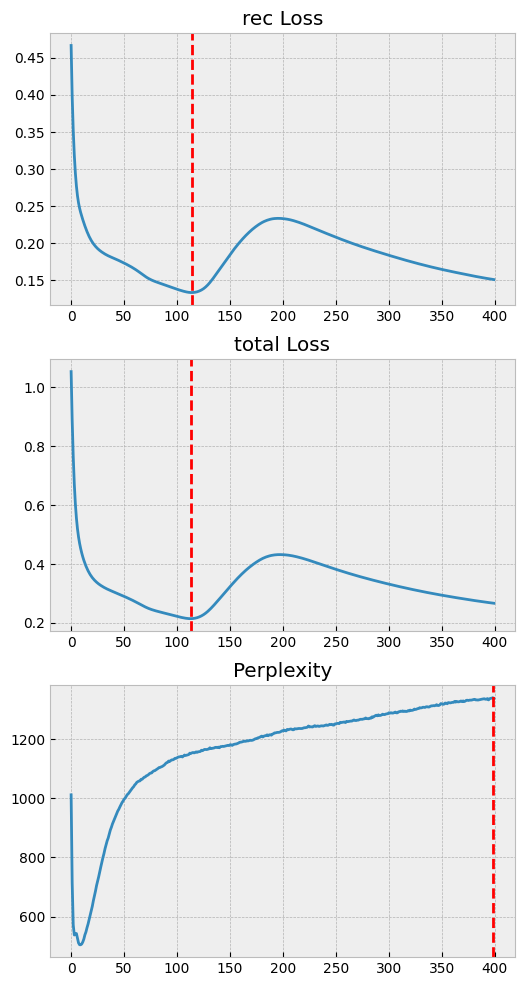

In [8]:
#plot these losses 
fig, ax = plt.subplots(3, 1, figsize=(6, 12))
ax[0].plot(losses[:, 0])
ax[0].set_title("rec Loss")
#draw a vertical line at the minimum rec loss
ax[0].axvline(losses[:, 0].argmin(), color='r', linestyle='--')
ax[1].plot(losses[:, 1])
ax[1].set_title("total Loss")
ax[1].axvline(losses[:, 1].argmin(), color='r', linestyle='--')
ax[2].plot(losses[:, 2])
ax[2].set_title("Perplexity")
ax[2].axvline(losses[:, 2].argmax(), color='r', linestyle='--')
plt.show()

In [19]:
import re
losses = torch.zeros(len(weight_files), 7)
val_losses = torch.zeros(len(weight_files), 4)
for i, wt in tqdm(enumerate(weight_files), total=len(weight_files)):
    numbers = [float(x) if '.' in x else int(x) for x in re.findall(r'\d+(?:\.\d+)?', wt.stem)]
    tt = torch.load(wt)
    _x = tt["losses"]
    losses[numbers[0], :] = torch.tensor([_x["total_g_loss"], _x["rec_loss"], _x["lpips_loss"], _x["codebook_loss"], _x["commit_loss"], _x["gloss"], _x["d_loss"]])
    _x = tt["val_epoch_losses"]
    val_losses[numbers[0], :] = torch.tensor([_x["total_g_loss"], _x["rec_loss"], _x["lpips_loss"], _x["perplexity"]])

100%|██████████| 400/400 [00:32<00:00, 12.37it/s]


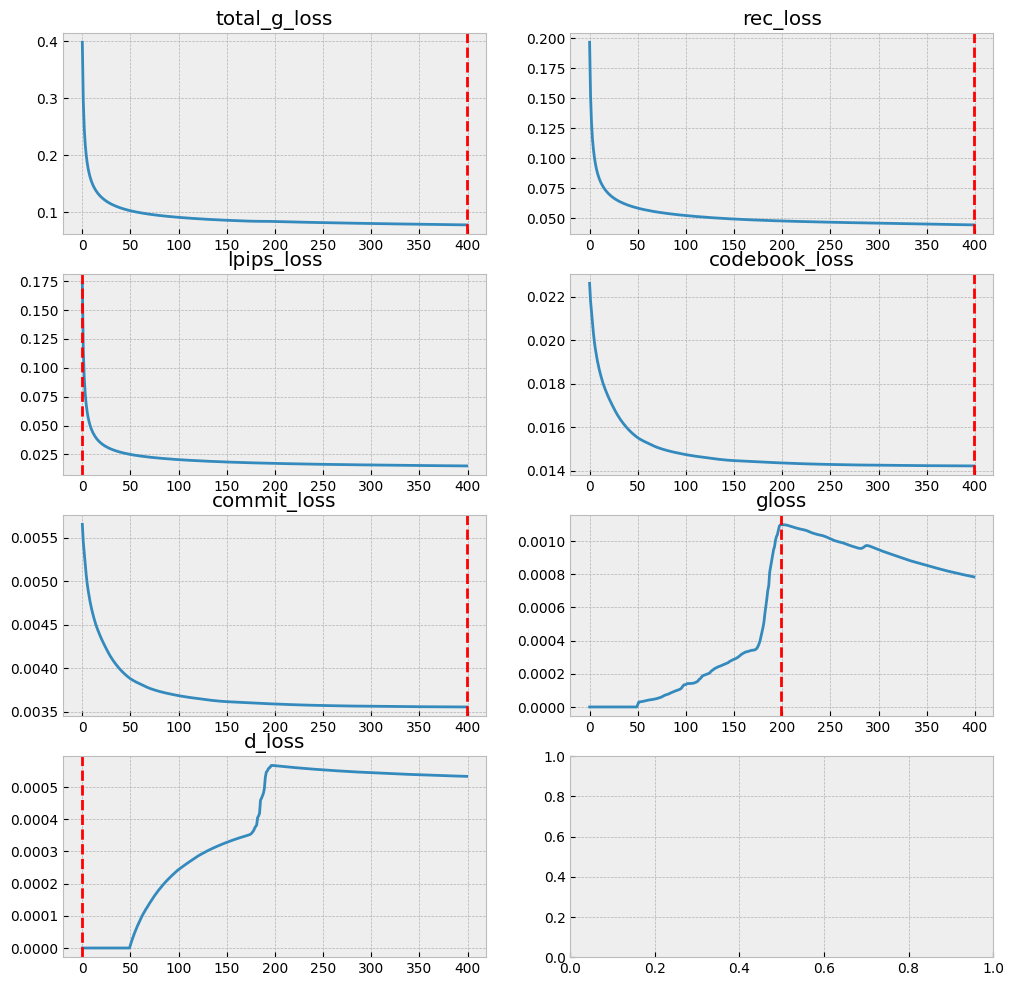

In [20]:
#plot these losses 
fig, ax = plt.subplots(4, 2, figsize=(12, 12))
ax.flat[0].plot(losses[:, 0])
ax.flat[0].set_title("total_g_loss")
#draw a vertical line at the minimum rec loss
ax.flat[0].axvline(losses[:, 0].argmin(), color='r', linestyle='--')

ax.flat[1].plot(losses[:, 1])
ax.flat[1].set_title("rec_loss")
ax.flat[1].axvline(losses[:, 1].argmin(), color='r', linestyle='--')

ax.flat[2].plot(losses[:, 2])
ax.flat[2].set_title("lpips_loss")
ax.flat[2].axvline(losses[:, 2].argmax(), color='r', linestyle='--')

ax.flat[3].plot(losses[:, 3])
ax.flat[3].set_title("codebook_loss")
ax.flat[3].axvline(losses[:, 3].argmin(), color='r', linestyle='--')

ax.flat[4].plot(losses[:, 4])
ax.flat[4].set_title("commit_loss")
ax.flat[4].axvline(losses[:, 4].argmin(), color='r', linestyle='--')

ax.flat[5].plot(losses[:, 5])
ax.flat[5].set_title("gloss")
ax.flat[5].axvline(losses[:, 5].argmax(), color='r', linestyle='--')

ax.flat[6].plot(losses[:, 6])
ax.flat[6].set_title("d_loss")
ax.flat[6].axvline(losses[:, 6].argmin(), color='r', linestyle='--')

plt.show()

100%|██████████| 400/400 [00:31<00:00, 12.71it/s]


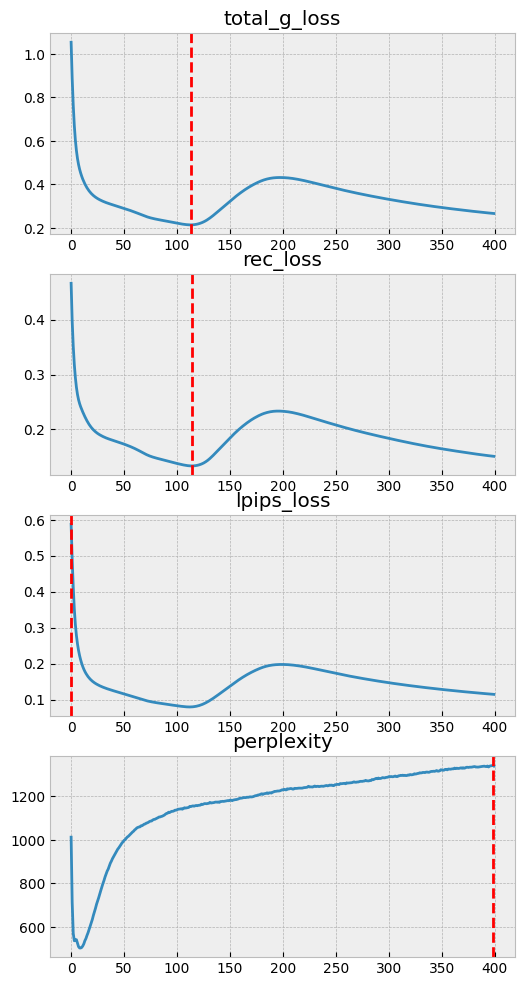

In [21]:
import re
losses = torch.zeros(len(weight_files), 4)
for i, wt in tqdm(enumerate(weight_files), total=len(weight_files)):
    numbers = [float(x) if '.' in x else int(x) for x in re.findall(r'\d+(?:\.\d+)?', wt.stem)]
    _x = torch.load(wt)["val_epoch_losses"]
    losses[numbers[0], :] = torch.tensor([_x["total_g_loss"], _x["rec_loss"], _x["lpips_loss"], _x["perplexity"]])
#plot these losses 
fig, ax = plt.subplots(4, 1, figsize=(6, 12))
ax.flat[0].plot(losses[:, 0])
ax.flat[0].set_title("total_g_loss")
ax.flat[0].axvline(losses[:, 0].argmin(), color='r', linestyle='--')

ax.flat[1].plot(losses[:, 1])
ax.flat[1].set_title("rec_loss")
ax.flat[1].axvline(losses[:, 1].argmin(), color='r', linestyle='--')

ax.flat[2].plot(losses[:, 2])
ax.flat[2].set_title("lpips_loss")
ax.flat[2].axvline(losses[:, 2].argmax(), color='r', linestyle='--')

ax.flat[3].plot(losses[:, 3])
ax.flat[3].set_title("perplexity")
ax.flat[3].axvline(losses[:, 3].argmax(), color='r', linestyle='--')

plt.show()